# Complimentary guide to computing transports in ECCO with ECCOv4-py

Re-writing a [tutorial](http://users.oden.utexas.edu/~tsmith/osm20_eccov4py_townhall_tsmith.html) written by Tim Smith for OSM20

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client
import ecco_v4_py as ecco

import warnings

In [2]:
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

Read in NetCDF files downloaded from the [ECCO Drive](https://ecco.jpl.nasa.gov/drive/login?dest=L2RyaXZlL2ZpbGVz)

## Binary Files
If you have binary files (like aste, North Atlantic strip, regional domains...), **ECCOv4-py** uses a wrapped function around the `open_mdsdataset` function from the `xmitgcm` package. Refer to original tutorial for more info.

In [3]:
# Specific to my local machine (Macbook)
download_dir = f'{os.getenv("WORK")}/eccov4r4'

In [4]:
print(os.getenv("WORK"))

/Users/ivanaescobar/work


In [5]:
%%time
ds = xr.open_mfdataset(glob(f'{download_dir}/nctiles_monthly/*/*/*.nc'))

CPU times: user 1min, sys: 3.62 s, total: 1min 3s
Wall time: 1min 3s


In [6]:
ds.data_vars

Data variables:
    ADVx_TH   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFxE_TH   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFyE_TH   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    UVELMASS  (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    VVELMASS  (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>

In [7]:
ds.UVELMASS.data

,Array,Chunk
Bytes,6.57 GB,21.06 MB
Shape,"(312, 50, 13, 90, 90)","(1, 50, 13, 90, 90)"
Count,936 Tasks,312 Chunks
Type,float32,numpy.ndarray


In [8]:
ds.ADVx_TH.data

,Array,Chunk
Bytes,6.57 GB,21.06 MB
Shape,"(312, 50, 13, 90, 90)","(1, 50, 13, 90, 90)"
Count,936 Tasks,312 Chunks
Type,float32,numpy.ndarray


In [9]:
ds.DFxE_TH

<xarray.DataArray 'DFxE_TH' (time: 312, k: 50, tile: 13, j: 90, i_g: 90)>
dask.array<concatenate, shape=(312, 50, 13, 90, 90), dtype=float32, chunksize=(1, 50, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    Z         (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    timestep  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
Attributes:
    units:      degC.m^3/s
    long_name:  Zonal      Diffusive Flux of Pot.Temperature

In [10]:
%%time
dsg = xr.open_dataset(f'{download_dir}/nctiles_grid/ECCO-GRID.nc')
print(f'Grid coordinate dataset is {dsg.nbytes/1e9:.02f} GB')

Grid coordinate dataset is 0.09 GB
CPU times: user 22.1 ms, sys: 2.28 ms, total: 24.3 ms
Wall time: 24.2 ms


Explicitly loading small data sets such as `dsg`.

In [11]:
dsg.load()
ds = ds.merge(dsg)

In [12]:
client = Client(n_workers=16) # cores available
client

Client Scheduler: tcp://127.0.0.1:50345 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 17.18 GB


__BEWARE__: This process overworked my laptop, I was using 56 cores in the `Client`! My laptop has 16 cores. 
You can find this out by using:
``` 
sysctl hw.ncpu
```
or by reading __About this Mac__

# Walkthrough of plotted results

### UVELMASS of 13 tiles
On sea surface, `k=0`, time mean over all available data, 1992-2017.

__BEWARE__: plotting command produced the following warning.
`distributed.worker - WARNING - Memory use is high but worker has no data to store to disk. Perhaps some other process is leaking memory?`
Was this because of __Dropbox__ running in the background?

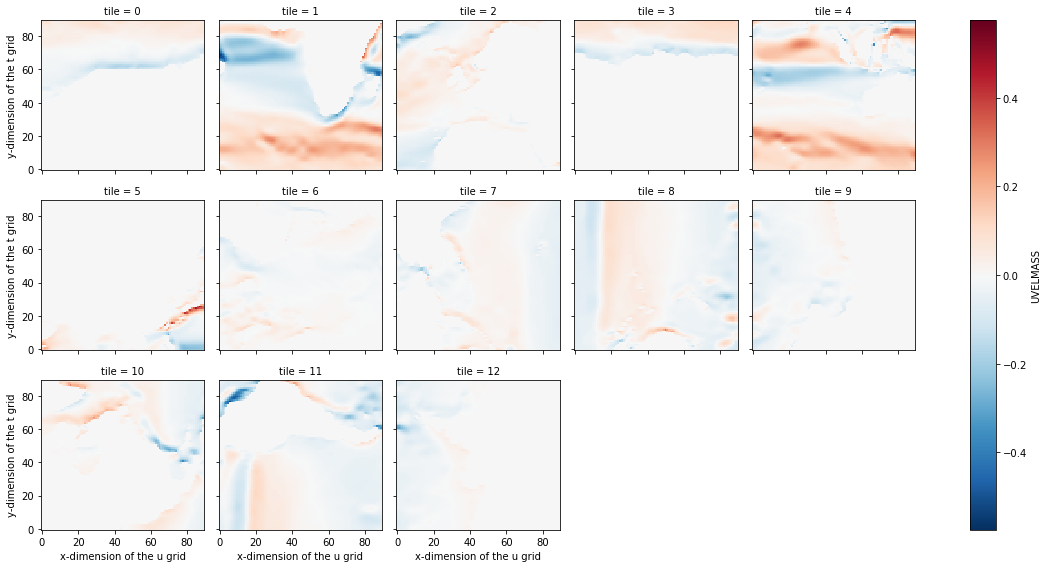

In [13]:
ds.UVELMASS.isel(k=0).mean('time').plot(col='tile',col_wrap=5,figsize=(16,8));

### Time mean surface currents

A common problem with plotting MITgcm results comes from funky velocity fields, `UVELMASS` and `VVELMASS`, on each tile. Here is the 'unrotated' field plotted on the global ocean

In [14]:
plt.rcParams.update({'figure.figsize':(12,6),'font.size':20,'axes.linewidth':1.5,'lines.linewidth':3})

Text(0.5,1,'Unrotated time mean surface currents')

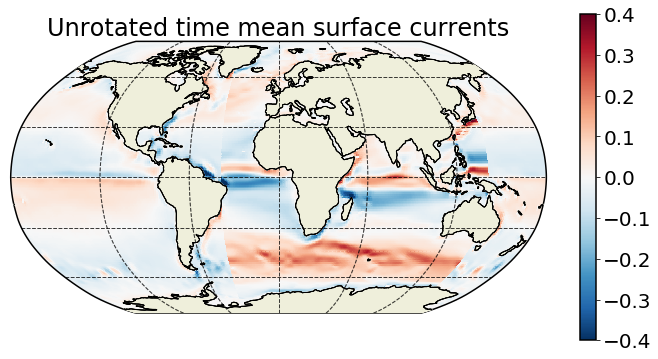

In [15]:
ecco.plot_proj_to_latlon_grid(ds.XG,ds.YC,ds.UVELMASS.isel(k=0).mean('time'),show_colorbar=True,cmin=-.4,cmax=.4)
plt.title('Unrotated time mean surface currents')

`ECCOv4-py` will fix that with their `UEVNfromUXVY` method

In [16]:
%%time
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds.UVELMASS,ds.VVELMASS,ds)

CPU times: user 1.43 s, sys: 35 ms, total: 1.47 s
Wall time: 1.46 s


In [ ]:
ecco.plot_proj_to_latlon_grid(ds.XG,ds.YC,uvel.isel(k=0).mean('time'),show_colorbar=True,cmin=-.4,cmax=.4)
plt.title('Time mean surface currents')

**This plot is crashing my local computer. Try on more cores with more memory**

### Atlantic meridional heat transport across 26$^\circ$N

Because we’re computing transport, we want the files containing `UVELMASS` and `VVELMASS` for volumetric transport, and `ADVx_TH`, `ADVy_TH` and `DFxE_TH`, `DFyE_TH` for the advective and diffusive components of heat transport, respectively.

In [ ]:
print(ecco.get_available_basin_names())

In [ ]:
%%time
mht = ecco.calc_meridional_heat_trsp(ds,lat_vals=26,basin_name='atlExt')

In [ ]:
%%time 
mht.load();

In [ ]:
mht.heat_trsp.plot(xlim=('1992','2018'))
plt.grid();

In [ ]:
def quick_depth_plot(xda): 
    fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True,sharex=True)
    
    # Time evolving
    plt.subplot(1,4,(1,3))
    xda.plot(y='Z',x='time',robust=True)
    plt.xlabel('')
    
    # time mean
    plt.subplot(1,4,4)
    xda.mean('time').plot(y='Z')
    plt.ylabel('')
    plt.grid()
    
    plt.tight_layout()
    
def depth_slice_plot(xda,z_mid=-500):

    for xda_slice in [xda.where(xda.Z>z_mid,drop=True),xda.where(xda.Z<z_mid,drop=True)]:
        quick_depth_plot(xda_slice)

In [ ]:
depth_slice_plot(mht.heat_trsp_z)

### Drake passage volume transport

using a pre-defined section of the ocean. 

In [ ]:
%%time
# easy as: ecco.calc_section_vol_trsp(ds,'Drake Passage')
# or:
dp = ecco.calc_section_vol_trsp(ds,pt1=[-68,-54],pt2=[-63,-66])

In [ ]:
%%time
dp.load();

In [ ]:
dp.vol_trsp.plot(xlim=['1992','2018'])
plt.grid();

In [ ]:
quick_depth_plot(dp.vol_trsp_z)

In [ ]:
plt.rcParams.update({'figure.figsize':(10,10)})
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YG,dp.maskS,projection_type='stereo',lat_lim=-45,show_grid_lines=False,cmap='gray_r');
plt.title('Drake Passage mask');

Content was borrowed from [this notebook](http://users.oden.utexas.edu/~tsmith/osm20_eccov4py_townhall_tsmith.html). This library package uses functions written in the `xgcm` and `xmitgcm` codes.

[Documentation](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Example_MHT.html#Grab-latitude-band:-26^\circN-array-as-an-example) for ECCOv4-py provides more info. 